# Signal processing
- __Spectral Analysis__
- __Fourier Transforms__
- __Frequency-domain Filter__
- __Windowing__
- __Spectrograms__
- __Signal Filters__ (Convolutions, FIR, IIR)

In [2]:
import numpy as np
import pandas as pd

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

In [4]:
import matplotlib as mpl

In [5]:
from scipy import fftpack

In [6]:
# this also works:
# from numpy import fft as fftpack

In [7]:
from scipy import signal

In [8]:
import scipy.io.wavfile

In [9]:
from scipy import io

### Spectral analysis / Fourier Transforms

* Fourier transform: F(v) of continuous signal f(t):
    * F(v) = sum{ f(t) * e^(-2piivt) dt }
    * complex-valued amplitude spectrum
* Inverse
    * f(t) = sum{ F(v) * e^(2piivt) dv }
    * continuous signal, infinite duration
* f(t) usually sampled from finite time duration, N uniformly spaced points.
    * used to build **Discrete Fourier Transform (DFT)** and **inverse DFT**.

In [10]:
# example simulated signal, pure sinusoid @ 1 Hz & 22 Hz, plus normal-distributed noise

def signal_samples(t):
    return (2 * np.sin(1 * 2 * np.pi * t) +
            3 * np.sin(22 * 2 * np.pi * t) +
            2 * np.random.randn(*np.shape(t)))

In [11]:
# we are interested in finding frequency spectrum of signal up to 30Hz.
# so we need to choose a sampling frequency of 60Hz
# we also want frequency resolution of 0.01Hz

np.random.seed(0)
B = 30.0
f_s = 2 * B
delta_f = 0.01

In [12]:
# N = number of reqd sample points; T = reqd time period (seconds)
N = int(f_s / delta_f)
T = N / f_s
N, T

(6000, 100.0)

In [13]:
# create array of sample times, uniformly spaced in time
t = np.linspace(0, T, N)

In [14]:
f_t = signal_samples(t)

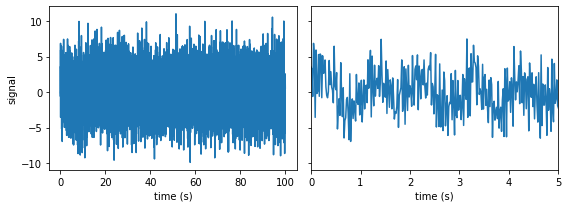

In [15]:
# plot with/without noise
fig, axes = plt.subplots(1, 2, figsize=(8, 3), sharey=True)
axes[0].plot(t, f_t)
axes[0].set_xlabel("time (s)")
axes[0].set_ylabel("signal")
axes[1].plot(t, f_t)
axes[1].set_xlim(0, 5)
axes[1].set_xlabel("time (s)")
fig.tight_layout()
#fig.savefig("ch17-simulated-signal.pdf")
#fig.savefig("ch17-simulated-signal.png")

In [16]:
# to see sinusoidal components in the signal:
F = fftpack.fft(f_t)

# return frequencies corresponding to each freq bin (fftfreq = helper function)
f = fftpack.fftfreq(N, 1/f_s)

In [17]:
# spectrum = symmetric at positive & negative frequencies, so
# we are only interested in positive frequency data.
mask = np.where(f >= 0)

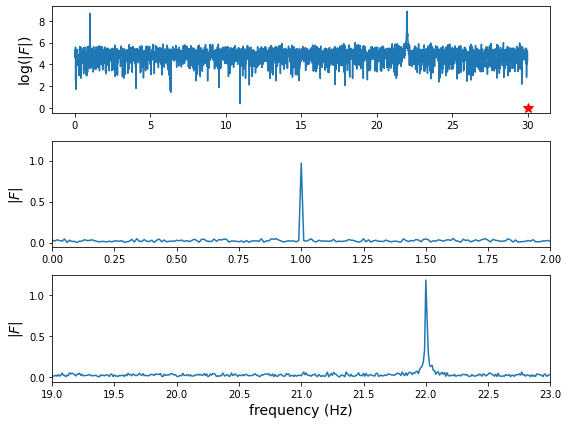

In [18]:
fig, axes = plt.subplots(3, 1, figsize=(8, 6))

# top panel: positive frequency components, logscale
axes[0].plot(
    f[mask], 
    np.log(abs(F[mask])), 
    label="real")

axes[0].plot(B, 0, 'r*', markersize=10)
axes[0].set_ylabel("$\log(|F|)$", fontsize=14)

axes[1].plot(
    f[mask], 
    abs(F[mask])/N, 
    label="real")

axes[1].set_xlim(0, 2)
axes[1].set_ylabel("$|F|$", fontsize=14)

axes[2].plot(
    f[mask], 
    abs(F[mask])/N, 
    label="real")

axes[2].set_xlim(19, 23)
axes[2].set_xlabel("frequency (Hz)", fontsize=14)
axes[2].set_ylabel("$|F|$", fontsize=14)

fig.tight_layout()
#fig.savefig("ch17-simulated-signal-spectrum.pdf")
#fig.savefig("ch17-simulated-signal-spectrum.png")

### frequency-domain filtering
* compute time domain-signal from frequency-domain signal via inverse FFT
* you can create frequency-domain filters by modifying spectrum first

In [19]:
# example: selecting only frequencies < 2Hz
F_filtered = F * (abs(f) < 2)

In [20]:
# compute inverse FFT on filtered data
f_t_filtered = fftpack.ifft(F_filtered)

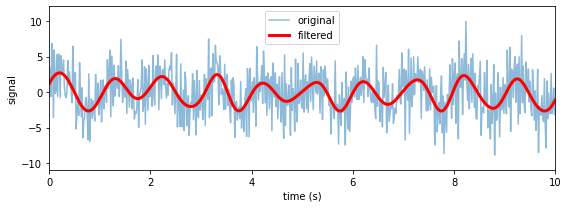

In [21]:
# plot original vs filtered.real component
fig, ax = plt.subplots(figsize=(8, 3))

ax.plot(t, f_t, label='original', alpha=0.5)
ax.plot(t, f_t_filtered.real, color="red", lw=3, label='filtered')

ax.set_xlim(0, 10)
ax.set_xlabel("time (s)")
ax.set_ylabel("signal")
ax.legend()
fig.tight_layout()
#fig.savefig("ch17-inverse-fft.pdf")
#fig.savefig("ch17-inverse-fft.png")

### Window Functions
* use case: improved quality & contrast of frequency spectrum
* definition: when multiplied by signal, modulates its magnitude -- approaches zero at beginning & end.
* Window options: Blackman, Hann, Hamming, Gaussian, Kaiser
* Use case: __reduces spectral "leakage" between nearby frequency bins__ - occurs when signal contains components not exactly divisible by sampling period.

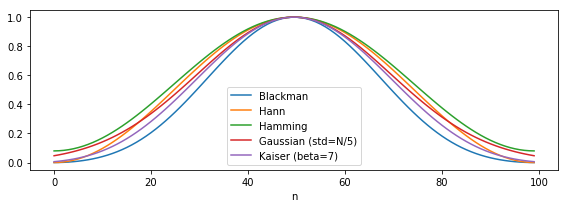

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3))
N = 100
ax.plot(signal.blackman(N),      label="Blackman")
ax.plot(signal.hann(N),          label="Hann")
ax.plot(signal.hamming(N),       label="Hamming")
ax.plot(signal.gaussian(N, N/5), label="Gaussian (std=N/5)")
ax.plot(signal.kaiser(N, 7),     label="Kaiser (beta=7)")
ax.set_xlabel("n")
ax.legend(loc=0)
fig.tight_layout()
#fig.savefig("ch17-window-functions.pdf")

In [46]:
# example:
# use window function before applying FFT to time-series signal

df = pd.read_csv(
    'temperature_outdoor_2014.tsv', 
    delimiter="\t", 
    names=["time", "temperature"])
df.head()

,time,temperature
0,1388530986,4.38
1,1388531586,4.25
2,1388532187,4.19
3,1388532787,4.06
4,1388533388,4.06


In [47]:
type(df.time)

pandas.core.series.Series

In [49]:
df.time = pd.to_datetime(
    df.time.values, unit="s").tz_localize('UTC').tz_convert('Europe/Stockholm')
df.head()

,time,temperature
0,2014-01-01 00:03:06+01:00,4.38
1,2014-01-01 00:13:06+01:00,4.25
2,2014-01-01 00:23:07+01:00,4.19
3,2014-01-01 00:33:07+01:00,4.06
4,2014-01-01 00:43:08+01:00,4.06


In [50]:
type(df.time)

pandas.core.series.Series

In [51]:
# set index, resample to 1 hour increments, window between April & June
df = df.set_index("time")
df = df.resample("H").ffill()
df = df[(df.index >= "2014-04-01") * (df.index < "2014-06-01")].dropna()

In [52]:
df.head()

,temperature
time,
2014-04-01 00:00:00+02:00,2.56
2014-04-01 01:00:00+02:00,2.31
2014-04-01 02:00:00+02:00,1.50
2014-04-01 03:00:00+02:00,0.56
2014-04-01 04:00:00+02:00,0.88


In [55]:
# once dataframe processed, prepare underlying NumPy arrays 
# so time-series data can be process using fftpack
time = df.index.astype('int64')/1.0e9
time[0:9]

Float64Index([1396303200.0, 1396306800.0, 1396310400.0, 1396314000.0,
              1396317600.0, 1396321200.0, 1396324800.0, 1396328400.0,
              1396332000.0],
             dtype='float64', name='time')

In [61]:
temperature = df.temperature.values
temperature[0:9], temperature.size

(array([2.56, 2.31, 1.5 , 0.56, 0.88, 1.81, 1.31, 1.06, 1.69]), 1464)

In [60]:
# apply Blackman window function (leakage reducer)
# need to pass length of sample array -- returns array of same length
window = signal.blackman(len(temperature))
window.size

1464

In [62]:
temperature_windowed = temperature * window
temperature_windowed[0:9]

array([-3.55271368e-17,  3.83467416e-06,  9.96039163e-06,  8.36700758e-06,
        2.33755870e-05,  7.51284590e-05,  7.83053617e-05,  8.62496280e-05,
        1.79624396e-04])

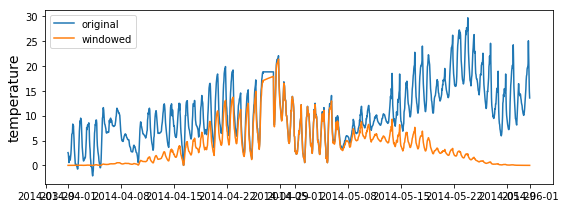

In [63]:
# before doing FFT, review original & windowed temp data

fig, ax = plt.subplots(figsize=(8, 3))

ax.plot(
    df.index, 
    temperature,
    label="original")

ax.plot(df.index, 
        temperature_windowed,
        label="windowed")

ax.set_ylabel("temperature", fontsize=14)
ax.legend(loc=0)
fig.tight_layout()
#fig.savefig("ch17-temperature-signal.pdf")

In [68]:
# use fft to find the spectrum
data_fft_windowed = fftpack.fft(temperature)

In [69]:
# use fftfreq to find frequency bins
f = fftpack.fftfreq(len(temperature), time[1]-time[0])

In [70]:
# select positive frequencies
mask = f > 0

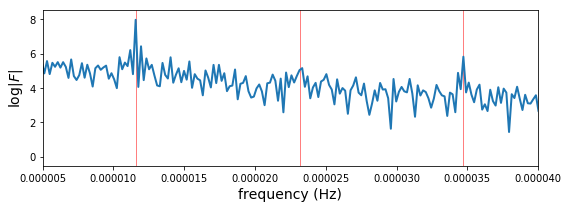

In [72]:
fig, ax = plt.subplots(figsize=(8, 3))

ax.set_xlim(0.000005, 0.00004)
ax.axvline(1./86400, color='r', lw=0.5)
ax.axvline(2./86400, color='r', lw=0.5)
ax.axvline(3./86400, color='r', lw=0.5)

ax.plot(
    f[mask], 
    np.log(abs(data_fft_windowed[mask])), lw=2)

ax.set_ylabel("$\log|F|$", fontsize=14)
ax.set_xlabel("frequency (Hz)", fontsize=14)
fig.tight_layout()
#fig.savefig("ch17-temperature-spectrum.pdf")

# below: spectrum of windowed temperature time series.
# dominant peak occurs at freq corresponding to 1-day period, and it higher harmonics.

### Spectrogram of Guitar sound
* use case: computing signal spectrum in segments instead of entire signal
* in this case: apply FFT on sliding window in time domain
* result: time-dependent spectrum (like equalizer graph on music eqpt)

In [328]:
# https://www.freesound.org/people/guitarguy1985/sounds/52047/

In [73]:
sample_rate, data = io.wavfile.read("guitar.wav")

In [74]:
sample_rate, data.shape

(44100, (1181625, 2))

In [75]:
data = data.mean(axis=1)

In [76]:
# recording duration = #samples / sampling rate (seconds)
data.shape[0] / sample_rate

26.79421768707483

In [77]:
# assume sampling 1/2 second at a time
N = int(sample_rate/2.0); N

22050

In [78]:
# generate frequency bins
f = fftpack.fftfreq(N, 1.0/sample_rate)

In [79]:
# generate array of sampling times
t = np.linspace(0, 0.5, N)

In [80]:
# frequency mask < 1000 Hz
mask = (f > 0) * (f < 1000)

In [81]:
# extract first N samples
subdata = data[:N]
# and apply fft to them
F = fftpack.fft(subdata)

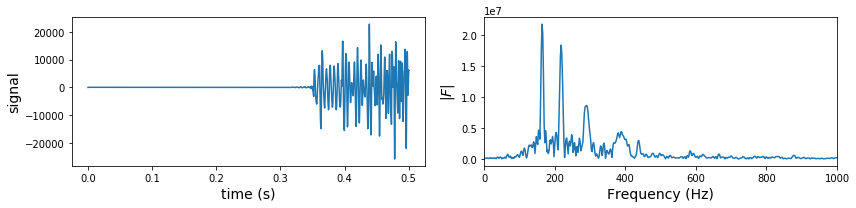

In [82]:
fig, axes = plt.subplots(1, 2, figsize=(12, 3))
axes[0].plot(t, subdata)
axes[0].set_ylabel("signal", fontsize=14)
axes[0].set_xlabel("time (s)", fontsize=14)
axes[1].plot(f[mask], abs(F[mask]))
axes[1].set_xlim(0, 1000)
axes[1].set_ylabel("$|F|$", fontsize=14)
axes[1].set_xlabel("Frequency (Hz)", fontsize=14)
fig.tight_layout()
#fig.savefig("ch17-guitar-spectrum.pdf")

# time-domain (left) = zero until first guitar string is plucked
# frequency-domain (right) = guitar's dominant frequencies

In [83]:
# now repeat analysis for subsequent segments
# create 2D spectrogram data object
N_max = int(data.shape[0] / N)

In [84]:
f_values = np.sum(1 * mask)

In [85]:
spect_data = np.zeros((N_max, f_values))

In [86]:
# use Blackman window to reduce frequency leakage
window = signal.blackman(len(subdata))

In [87]:
# loop over array slices, apply window, apply FFT, store subset
for n in range(0, N_max):
    subdata = data[(N * n):(N * (n + 1))]
    F = fftpack.fft(subdata * window)
    spect_data[n, :] = np.log(abs(F[mask]))

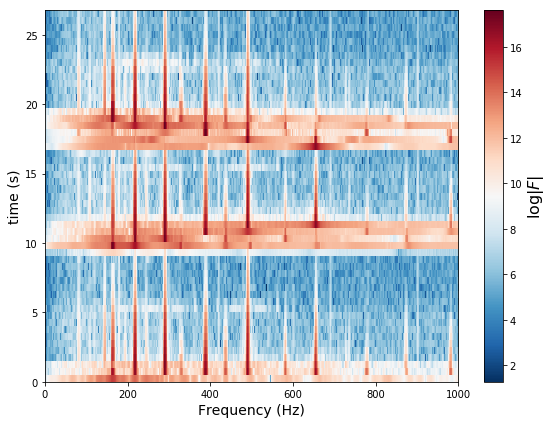

In [88]:
# use matplotlib "imshow" option

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

p = ax.imshow(spect_data, origin='lower',
              extent=(0, 1000, 0, data.shape[0] / sample_rate),
              aspect='auto',
              cmap=mpl.cm.RdBu_r)

cb = fig.colorbar(p, ax=ax)
cb.set_label("$\log|F|$", fontsize=16)
ax.set_ylabel("time (s)", fontsize=14)
ax.set_xlabel("Frequency (Hz)", fontsize=14)
fig.tight_layout()
#fig.savefig("ch17-spectrogram.pdf")
#fig.savefig("ch17-spectrogram.png")

### Signal filters
* Filters in previous examples couldn't be done in real time - buffering problems.

### Convolution filters
* fourier transformation property: inverse FFT of product of two functions (ex: signal spectrum + filter shape) is convolution of the two functions' IFFTs. 
* To apply filter Hk to spectrum Xk of signal xn, we can find convolution ox xn with hm (the IFFT of Hk).

In [102]:
N,T

(22050, 100.0)

In [103]:
# use convolve function to perform inverse Fourier transform the frequency response function
# use the result "h" as a kernel to convolve the original time-domain signal f_t.

t = np.linspace(0,T,N); t

array([0.00000000e+00, 4.53535308e-03, 9.07070615e-03, ...,
       9.99909293e+01, 9.99954646e+01, 1.00000000e+02])

In [96]:
f_t = signal_samples(t)

In [97]:
H = abs(f)<2

In [98]:
h = fftpack.fftshift(fftpack.ifft(H))

In [100]:
# use mode="same"  to set output array size equal to the first input.
# or use mode="valid" to only use elements not relying on zero padding.

f_t_filtered_conv = signal.convolve(f_t, h, mode='same')

/home/bjpcjp/anaconda3/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


ValueError: x and y must have same first dimension, but have shapes (22050,) and (6000,)

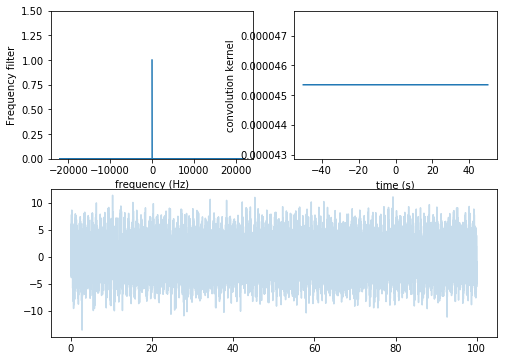

In [104]:
fig = plt.figure(figsize=(8, 6))
ax = plt.subplot2grid((2,2), (0,0))

ax.plot(f, H)
ax.set_xlabel("frequency (Hz)")
ax.set_ylabel("Frequency filter")
ax.set_ylim(0, 1.5)

ax = plt.subplot2grid((2,2), (0,1))
ax.plot(t - t[-1]/2.0, h.real)
ax.set_xlabel("time (s)")
ax.set_ylabel("convolution kernel")

ax = plt.subplot2grid((2,2), (1,0), colspan=2)
ax.plot(t, f_t,                                 label='original', alpha=0.25)
ax.plot(t, f_t_filtered.real,      "r",   lw=2, label='filtered in frequency domain')
ax.plot(t, f_t_filtered_conv.real, 'b--', lw=2, label='filtered with convolution')
ax.set_xlim(0, 10)
ax.set_xlabel("time (s)")
ax.set_ylabel("signal")
ax.legend(loc=2)

fig.tight_layout()

### Infinite & Finite Impulse Response (IIR, FIR) filters
* special cases of convolution-like filters
* FIR:     y(n) = sum(k=0..M, b(k)x(n-k)
* IIR: a(0)y(n) = sum(k=0..M, b(k)x(n-k) - sum(k=1..N, a(k)y(n-k)
* Finding a(k) & b(k) = filter design; can be found via SciPy.signal module functions like *firwin()*.

### FIR

In [105]:
# firwin args:
# n = number of vals in ak (# of "taps)
# cutoff = low-pass transition freq (units of Nyquist frequency)
# nyq    = Nyquist frequency scale
# window = window function type

n = 101
f_s = 1.0 / 3600
nyq = f_s/2

b = signal.firwin(n, cutoff=nyq/12, nyq=nyq, window="hamming")

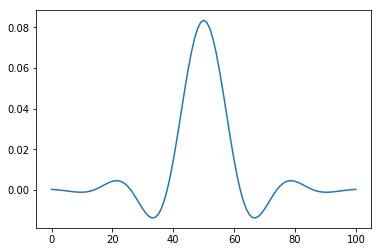

In [106]:
# sequence of coefficients b(k) that defines FIR filter
plt.plot(b);

In [107]:
# use b(k) to find amplitude & phase of filter response
f, h = signal.freqz(b)

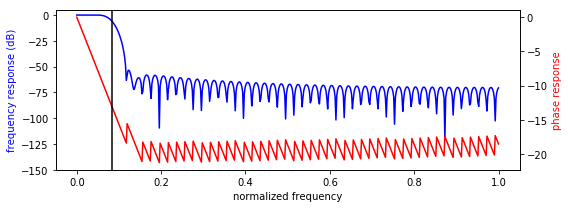

In [108]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3))
h_ampl = 20 * np.log10(abs(h))
h_phase = np.unwrap(np.angle(h))
ax.plot(f/max(f), h_ampl, 'b')
ax.set_ylim(-150, 5)
ax.set_ylabel('frequency response (dB)', color="b")
ax.set_xlabel(r'normalized frequency')
ax = ax.twinx()
ax.plot(f/max(f), h_phase, 'r')
ax.set_ylabel('phase response', color="r")
ax.axvline(1.0/12, color="black")
fig.tight_layout()
#fig.savefig("ch17-filter-frequency-response.pdf")

In [109]:
temperature_filtered = signal.lfilter(b, 1, temperature)

/home/bjpcjp/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]


In [110]:
temperature_median_filtered = signal.medfilt(temperature, 25)

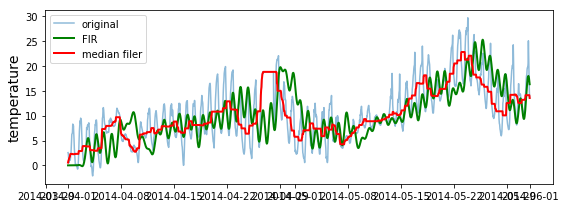

In [111]:
fig, ax = plt.subplots(figsize=(8, 3))
ax.plot(df.index, temperature, label="original", alpha=0.5)
ax.plot(df.index, temperature_filtered, color="green", lw=2, label="FIR")
ax.plot(df.index, temperature_median_filtered, color="red", lw=2, label="median filer")
ax.set_ylabel("temperature", fontsize=14)
ax.legend(loc=0)
fig.tight_layout()
#fig.savefig("ch17-temperature-signal-fir.pdf")

### IIR
* predefined types: butterworth, chebyshev I/II, elliptic

In [112]:
# example: 
# high-pass Butterworth filter, crit frequency = 7/365

b, a = signal.butter(2, 14/365.0, btype='high')
b, a

(array([ 0.91831745, -1.8366349 ,  0.91831745]),
 array([ 1.        , -1.82995169,  0.8433181 ]))

In [113]:
# apply filter to input signal (temp dataset)
temperature_filtered_iir = signal.lfilter(b, a, temperature)

In [114]:
# alternative: filters both fwd & bkwd
temperature_filtered_filtfilt = signal.filtfilt(b, a, temperature)

/home/bjpcjp/anaconda3/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


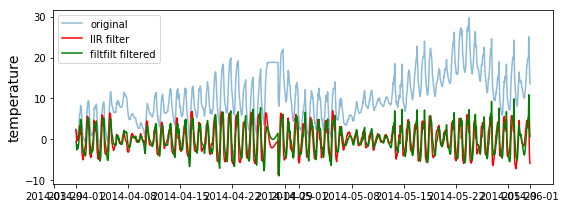

In [115]:
fig, ax = plt.subplots(figsize=(8, 3))

ax.plot(
    df.index, temperature, label="original", alpha=0.5)
ax.plot(
    df.index, temperature_filtered_iir, color="red", label="IIR filter")
ax.plot(
    df.index, temperature_filtered_filtfilt, color="green", label="filtfilt filtered")

ax.set_ylabel("temperature", fontsize=14)
ax.legend(loc=0)
fig.tight_layout()
#fig.savefig("ch17-temperature-signal-iir.pdf")

* Applying filters directly to audio/image data
* Example: use __lfilter__ to apply filter to audio signals.
* Use case: create "naive echo" effect with FIR filter that repeats past signals with a time delay.

In [121]:
b = np.zeros(10000)
b[0] = b[-1] = 1
b /= b.sum()
data_filt = signal.lfilter(b,1,data)

/home/bjpcjp/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]


In [122]:
# write to wav file
io.wavfile.write("guitar-echo.wav", sample_rate, 
                 np.vstack([
                     data_filt, data_filt]).T.astype(np.int16))